## Exploit indexing for search
**Task**: given a query, find documents by exploiting the Vector Space Model

**Steps**: 
1. represent documents in the feature space (eventually reducing dimensionality)
2. vectorize query
3. match query and documents using cosine similarity

In [1]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import spacy
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## Embedding docs in the feature space using TfIdf

In [2]:
dataset_file = '../data/wiki_dataset.json'
with open(dataset_file, 'r') as infile:
    dataset = json.load(infile)
docs = dataset['docs']
queries = dataset['queries']
nlp = spacy.load("en_core_web_sm")
tokens = lambda text: [x.lemma_ for x in nlp(text) if x.pos_ not in ['PUNCT', 'SPACE'] and not x.is_stop]

In [3]:
V = CountVectorizer()
tf_idf = TfidfTransformer(use_idf=True)

In [4]:
pseudo_docs = [" ".join(tokens(doc)) for doc in docs]

In [5]:
X = tf_idf.fit_transform(V.fit_transform(pseudo_docs))

In [6]:
X.shape

(3128, 22031)

## Reduce dimensionality for visualization (and potentially for more efficient matching)
See a PCA introduction [here](pca)

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [8]:
pca = PCA(n_components=2)

In [9]:
Z = pca.fit_transform(X.toarray())

### Example of visualization of vectors

In [10]:
for i, (k, v) in enumerate(queries.items()):
    if len(v) > 10:
        print(i, k, len(v))

0 italy 126
1 endemism 151
2 association football 702
3 departments of france 208
4 communes of france 182
5 germany 104
6 netherlands 65
7 forward (association football) 69
8 canadians 104
9 rock music 71
10 republican party (united states) 64
11 democratic party (united states) 84
12 france 98
13 defender (association football) 81
14 marine (ocean) 85
15 australian football league 54
16 united kingdom 126
17 united states 345
18 england 63
19 football (soccer) 99
20 family (biology) 226
21 types of inhabited localities in russia 100
22 village#russia 80
23 unincorporated area 125
24 2010 united states census 80
25 conservative party (uk) 58
26 canada 57
27 new york (state) 79
28 first-class cricket 56


In [11]:
q_sample = [(x, y) for x, y in queries.items()][11:15]

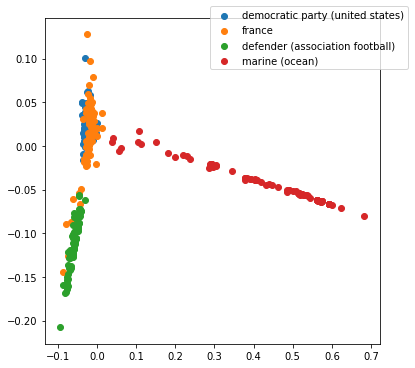

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
for q, dcs in q_sample:
    ax.scatter(Z[dcs,0], Z[dcs,1], label=q)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

## Vectorize (and visualize) queries

In [13]:
query_texts = [(query, " ".join(tokens(query))) for query in queries.keys()]

In [14]:
q_matrix = tf_idf.transform(V.transform([y for x, y in query_texts]))

In [15]:
Q = pca.transform(q_matrix.toarray())

In [17]:
q_index = 11
query_texts[q_index]
q = Q[q_index]

In [18]:
print(query_texts[q_index][0])

democratic party (united states)


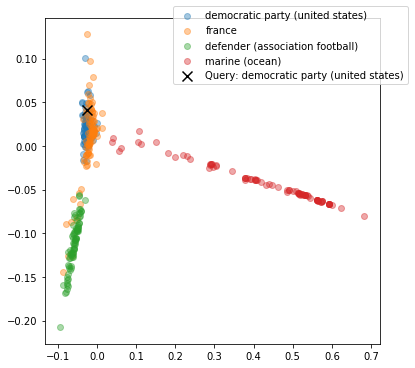

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
for qv, dcs in q_sample:
    ax.scatter(Z[dcs,0], Z[dcs,1], label=qv, alpha=0.4)
ax.scatter(q[0], q[1], label='Query: {}'.format(query_texts[q_index][0]), s=100, marker='x', c='#000000')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

## Query answering
We are ready to exploit the contiguity among queries and documents to answer queries.

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

## Matching the original data

In [21]:
matching = cosine_similarity(q_matrix, X)

In [22]:
matching.shape

(29, 3128)

### Get ranking

In [23]:
answers = [(x, y) for x, y in sorted(enumerate(matching[q_index]), key=lambda x: -x[1]) if y > 0]

In [24]:
expected = set(queries[query_texts[q_index][0]])

In [25]:
for answer, score in answers:
    print(answer, score, answer in expected)
    print(docs[answer], '\n')

2560 0.4083560221506487 True
The 1897 South Carolina United States Senate election was a unanimous election of the Democratic nominee on January 26, 1897 to select the U.S. Senator from the state of South Carolina. The Democratic primary election was held on August 26, 1896 and September 9. Prior to the ratification of the 17th Amendment to the United States Constitution, U.S. Senators were elected by the state legislature and not through the direct election by the people of the state. However, the Democratic Party of South Carolina organized primary elections for the U.S. Senate beginning in 1896 and the General Assembly would confirm the choice of the Democratic voters. Conservative Democratic Joseph H. Earle won the Democratic primary and was elected by the General Assembly for a six-year term. 

1042 0.3261660827074844 True
The 1988 United States elections was held on November 8, and elected the members of the 101st United States Congress. The Republican Party retained the presiden

962 0.038715472835041335 False
Symco is an unincorporated community located in the town of Union, Waupaca County, Wisconsin, United States. Symco is located on Wisconsin Highway 22 at the Little Wolf River, north-northeast of Manawa. 

163 0.03871307892257653 False
Hannah Junction is an unincorporated community in Grand Forks County, North Dakota, United States. Hannah Junction is located along a BNSF Railway line northwest of Larimore. 

132 0.038703467816274505 False
Dick Krzywicki (born Ryszard Lech Krzywicki on 2 February 1947 in Penley, Flintshire) is a Welsh former professional footballer and Wales international. He was born to Polish parents. During his career he played for West Bromwich Albion, Huddersfield Town, Scunthorpe United, Northampton Town and Lincoln City. He was the first West Bromwich Albion substitute to enter the field in a League Cup match when he replaced Doug Fraser against Manchester City in October 1966. He went on to score a goal as Albion progressed by a 4–

In [40]:
retrieved = set([x for x, y in answers])

In [41]:
expected = set(queries[query_texts[q_index][0]])

In [42]:
print('Precision: {}'.format(len(retrieved.intersection(expected)) / len(retrieved)))

Precision: 0.12861736334405144


In [43]:
print('Recall: {}'.format(len(retrieved.intersection(expected)) / len(expected)))

Recall: 0.9523809523809523


## Comparison with boolean retrieval

In [44]:
boolean_index = defaultdict(lambda: set())
for i, doc in enumerate(pseudo_docs):
    for token in doc.split():
        boolean_index[token].add(i)

In [45]:
boolean_query = tokens(query_texts[q_index][0])

### AND query

In [46]:
boolean_answer = None
for token in boolean_query:
    if boolean_answer is None:
        boolean_answer = boolean_index[token]
    else:
        boolean_answer = boolean_answer.intersection(boolean_index[token])

In [47]:
print('Precision: {}'.format(len(boolean_answer.intersection(expected)) / (len(boolean_answer)+1)))
print('Recall: {}'.format(len(boolean_answer.intersection(expected)) / len(expected)))

Precision: 0.0
Recall: 0.0


In [48]:
boolean_answer = None
for token in boolean_query:
    if boolean_answer is None:
        boolean_answer = boolean_index[token]
    else:
        boolean_answer = boolean_answer.union(boolean_index[token])

In [49]:
print('Precision: {}'.format(len(boolean_answer.intersection(expected)) / len(boolean_answer)))
print('Recall: {}'.format(len(boolean_answer.intersection(expected)) / len(expected)))

Precision: 0.30158730158730157
Recall: 0.6785714285714286


In [50]:
c = 0
for d in expected:
    if d not in retrieved:
        print(docs[d], '\n')
        c += 1
    if c > 5:
        break

Charles Albert "Charlie" Hall, Jr. (May 7, 1930 – November 20, 2014) was an American firefighter, labor activist, and politician. Born in Miami, Florida, Hall received his bachelor's degree in labor from Florida International University and his certificate in the trade union program from the Harvard Business School. He served as a firefighter for the City of Miami from 1952 to 1979. He was also involved with his labor union. He was also a professor at Florida International University and served on the Miami-Dade Ethics Commission. From 1980 to 1982, Hall served in the Florida House of Representatives and was a Democrat. Hall died in Tallahassee, Florida. 

Juanita Mitchell White (October 12, 1929 – May 6, 2011) was an American politician. From Hardeeville, South Carolina, White lived in Philadelphia, Pennsylvania, where she grew up in and raised her family. She then returned to Jasper County, South Carolina. White served in the South Carolina House of Representatives from 1980 to 1995 